In [ ]:
"""
This script tests lime and can use both a UNet to segment the image or no UNet by setting the use_unet boolean. The UNet is from reference [9] from the presentation.
"""

In [ ]:
use_unet = True

In [22]:
import keras
from keras.models import load_model
from keras.preprocessing.image import  save_img, load_img, image, ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from python.lime.utils.dice import dice_coef
import numpy as np
from lime.lime_image import LimeImageExplainer
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import os

In [16]:
cwd =  os.path.abspath('')

model = load_model(cwd + "/python/model_creating/models/masked_model.h5")
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [6]:
def dice_error(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [17]:
unet_model = load_model('python/lime/unet_model_16_filters_kernel2x2.h5',custom_objects={'dice_coef':dice_coef,'dice_error':dice_error})

In [18]:
random_seed = 0
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=random_seed)

# segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=1,
#                                                     sigma=0.8, min_size=20)

In [52]:
# test images saved in the python directory

#path = os.getcwd() + '\\python\\data\\test\\PNEUMONIA\\person47_virus_99.jpeg'

path = os.getcwd() + '\\python\\lime\\xray-chest-pneumonia.jpg'

# load normal image
test_image = load_img(path, target_size=(255,255,3))
test_image = image.img_to_array(test_image)
test_image = test_image * (1. / 255)
test_image = np.expand_dims(test_image, axis=0)

if use_unet:
    # if UNet is being used, mask the image and resave it
    img = load_img(path, color_mode='grayscale', target_size=(128,128))
    img = image.img_to_array(img)
    img = img * (1. / 255)
    img = np.expand_dims(img, axis=0)

    sgm = unet_model.predict(img).argmax(axis=3)[0]
    img_mask = sgm > 0
    img_mask = np.where(img_mask, img[...,0][0], 0)
    img_mask = np.reshape(img_mask, (128,128,1))

    mask_path = os.getcwd() + '\\python\\masked_image.jpg'

    save_img(mask_path, img_mask)

    lime_image = load_img(mask_path, target_size=(255,255,3))
    lime_image = image.img_to_array(lime_image)
    lime_image = lime_image * (1. / 255)
    lime_image = np.expand_dims(lime_image, axis=0)
else:
    lime_image = test_image


explainer = LimeImageExplainer()

In [53]:
explanation = explainer.explain_instance(lime_image[0], model.predict_proba, labels=["NORMAL", "PNEUMONIA"], 
                                         top_labels=2, num_samples=100, random_seed=0, segmentation_fn = segmentation_fn)

[[1]]


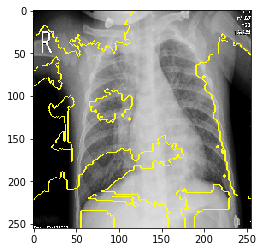

In [54]:
# 0 is normal, 1 is pneumonia
print(model.predict_classes(test_image))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,hide_rest=False, num_features=100, min_weight=6e-6)
plt.imshow(mark_boundaries(test_image[0], mask))
plt.show()

In [234]:
explanation.local_exp

{0: [(43, 7.2921043254680835e-06),
  (39, 6.926467931100376e-06),
  (44, -5.381741413341324e-06),
  (41, 5.296697489020958e-06),
  (19, -5.021724759241755e-06),
  (42, 4.966939681354847e-06),
  (26, 4.59912741401392e-06),
  (33, 4.476639888643179e-06),
  (7, -3.528559436494436e-06),
  (27, -3.474715689431536e-06),
  (9, -3.315953986420994e-06),
  (36, 3.166417095693394e-06),
  (0, 3.0899735902853664e-06),
  (31, -3.0032429263969306e-06),
  (23, -2.9679602094335074e-06),
  (30, -2.93842917348955e-06),
  (8, 2.9123137932339586e-06),
  (3, -2.895719636965136e-06),
  (13, 2.856749114659149e-06),
  (11, 2.7124173115764257e-06),
  (12, 2.704886599366121e-06),
  (4, 2.6488190085561287e-06),
  (15, 2.5977045519551756e-06),
  (34, 2.5274378480959835e-06),
  (37, -2.2978419219977703e-06),
  (6, -2.296040441839698e-06),
  (29, -2.2771552275144043e-06),
  (2, -2.2667446411425072e-06),
  (49, -2.222355502411321e-06),
  (18, -2.0021779988703366e-06),
  (20, 1.8504172274207602e-06),
  (1, 1.848327247